## Predict sentiment score of cryptocurrencies with Fedot.Industrial

By combining historical sentiment data for 4 cryptocurrencies, extracted from EODHistoricalData31 and made available, with historical price data for the same cryptocurrencies, extracted from CryptoDataDownload32, was created the **BitcoinSentiment, EthereumSentiment, CardanoSentiment, and BinanceCoinSentiment** datasets, with 332, 356, 107, and 263 total instances, respectively. In all four datasets, the **predictors** are hourly **close price (in USD)** and **traded volume** for each respective cryptocurrency during a day, resulting in 2-dimensional time series of length 24. The **target variable** is the **normalized sentiment score** on the day spanned by the timepoints. The datasets were split
into train and test sets by randomly selecting 30% of each set as test data.
Link to the dataset - https://www.kaggle.com/datasets/gautamchettiar/historical-sentiment-data-btc-eth-bnb-ada

In [1]:
import pandas as pd
from functools import partial
from fedot_ind.api.utils.path_lib import PROJECT_PATH
from fedot.core.pipelines.pipeline_builder import PipelineBuilder
from fedot_ind.tools.loader import DataLoader
from fedot_ind.core.repository.initializer_industrial_models import IndustrialModels
from examples.example_utils import init_input_data, calculate_regression_metric
from golem.core.tuning.sequential import SequentialTuner
from fedot.core.pipelines.tuning.tuner_builder import TunerBuilder
from fedot.core.repository.quality_metrics_repository import RegressionMetricsEnum

The list of basic fedot industrial models for experiment are shown below. We are using simple linear machine learning pipelines with 3 different feature generators: Statistical, Recurrence, Topological. And for each of them we add PCA transformation with 90 % of explained dispersion.

In [2]:
model_dict = {
    'regression_with_statistical_features': PipelineBuilder().add_node('quantile_extractor',
                                                                       params={'window_size': 5}).add_node('ridge'),
    'regression_pca_with_statistical_features': PipelineBuilder().add_node('quantile_extractor',
                                                                           params={'window_size': 5}).
    add_node('pca', params={'n_components': 0.9}).add_node('ridge'),
    'regression_with_recurrence_features': PipelineBuilder().add_node('recurrence_extractor',
                                                                           params={'window_size': 20}).add_node('ridge'),
    'regression_pca_with_recurrence_features': PipelineBuilder().add_node('recurrence_extractor',
                                                                           params={'window_size': 20}).
    add_node('pca', params={'n_components': 0.9}).add_node('ridge'),
    'regression_with_topological_features': PipelineBuilder().add_node('topological_extractor',
                                                                           params={'window_size': 20}).
    add_node('pca', params={'n_components': 0.9}).add_node('ridge'),
    'regression_pca_with_topological_features': PipelineBuilder().add_node('topological_extractor',
                                                                           params={'window_size': 20}).
    add_node('pca', params={'n_components': 0.9}).add_node('ridge')
}

dataset_name = 'EthereumSentiment'
data_path = PROJECT_PATH + '/examples/data'
tuning_params = {'task': 'regression',
                 'metric': RegressionMetricsEnum.RMSE,
                 'tuning_timeout':10,
                 'tuning_iterations':100}

In [3]:
def evaluate_industrial_model(train_data, test_data, task:str = 'regression'):
    metric_dict = {}
    input_data = init_input_data(train_data[0], train_data[1], task=task)
    val_data = init_input_data(test_data[0], test_data[1], task=task)
    with IndustrialModels():
        for model in model_dict.keys():
            print(f'Current_model - {model}')
            pipeline = model_dict[model].build()
            pipeline.fit(input_data)
            features = pipeline.predict(val_data).predict
            metric = calculate_regression_metric(test_target=test_data[1], labels=features)
            metric_dict.update({model: metric})
    return metric_dict

def tuning_industrial_pipelines(pipeline, tuning_params, train_data):
    input_data = init_input_data(train_data[0], train_data[1], task=tuning_params['task'])
    pipeline_tuner = TunerBuilder(input_data.task) \
        .with_tuner(partial(SequentialTuner, inverse_node_order=True)) \
        .with_metric(tuning_params['metric']) \
        .with_timeout(tuning_params['tuning_timeout']) \
        .with_iterations(tuning_params['tuning_iterations']) \
        .build(input_data)

    pipeline = pipeline_tuner.tune(pipeline)
    return pipeline

Now we must download the dataset. It could be done by using `DataReader` class that implemented as attribute of `FedotIndustrial` class. This class firstly tries to read the data from local project folder `data_path` and then if it is not possible, it downloads the data from the UCR/UEA archive. The data will be saved in the `data` folder.

In [4]:
_, train_data, test_data = DataLoader(dataset_name=dataset_name).read_train_test_files(
            dataset_name=dataset_name,
            data_path=data_path)

2023-10-09 14:16:54,968 - Reading data from D:\WORK\Repo\Industiral\IndustrialTS/examples/data/EthereumSentiment


In [5]:
input_data = init_input_data(train_data[0], train_data[1], task=tuning_params['task'])
val_data = init_input_data(test_data[0], test_data[1], task=tuning_params['task'])

Lets check our data.

In [6]:
input_data.features.shape

(249, 2, 24)

Lets visualise our predictors.

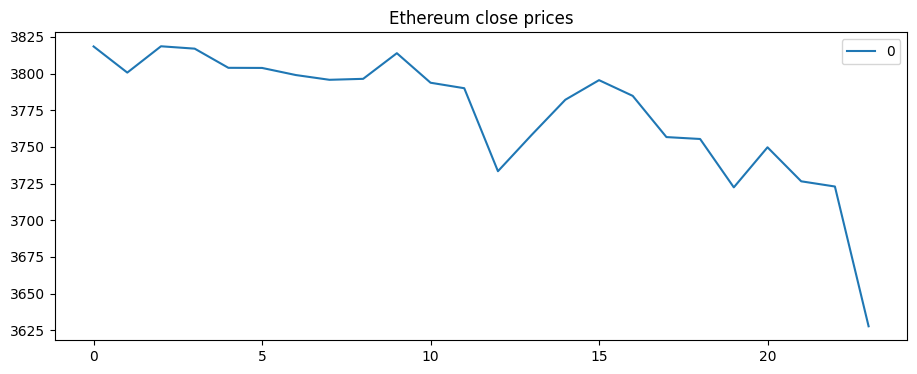

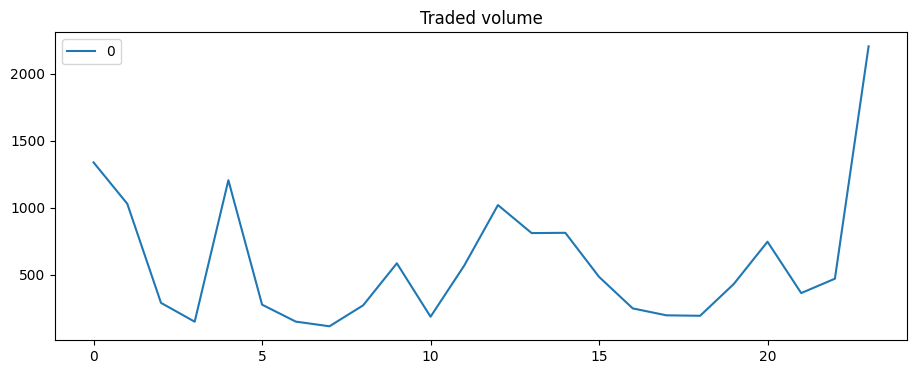

In [23]:
from matplotlib import pyplot as plt
pd.DataFrame(input_data.features[1, 0, :]).plot(title='Ethereum close prices')
pd.DataFrame(input_data.features[1, 1, :]).plot(title='Traded volume')
plt.show()

Next steps are quite straightforward. We need to fit the model and then predict the values for the test data just like for any other model in sklearn.

At the `fit` stage FedotIndustrial will transform initial time series data into features dataframe and will train regression model.

In [8]:
metric_dict = evaluate_industrial_model(train_data,test_data)

Current_model - regression_with_statistical_features
Current_model - regression_pca_with_statistical_features
Current_model - regression_with_reccurence_features
Current_model - regression_pca_with_reccurence_features
Current_model - regression_with_topological_features
Current_model - regression_pca_with_topological_features


At the end of the experiment we can obtain the desired metric values using `calculate_regression_metric` method. Now there are five available metrics for classification task:
- `explained_variance_score`
- `max_error`
- `mean_absolute_error`
- `mean_squared_error`
- `d2_absolute_error_score`.
- `median_absolute_error`
- `r2_score`

In [9]:
df_baseline = pd.concat([x for x in metric_dict.values()],axis=1)
df_baseline.columns = list(metric_dict.keys())
df_baseline = df_baseline.T
df_baseline.sort_values(by='root_mean_squared_error:')

,r2_score:,mean_squared_error:,root_mean_squared_error:,mean_absolute_error,median_absolute_error,explained_variance_score,max_error,d2_absolute_error_score
regression_pca_with_statistical_features,0.269364,0.052583,0.229310,0.172408,0.131389,0.286138,0.736407,0.190477
regression_pca_with_reccurence_features,-0.049641,0.075541,0.274848,0.223042,0.202066,-0.007871,0.706734,-0.047269
regression_with_topological_features,-0.053231,0.075800,0.275317,0.221374,0.186739,-0.008897,0.732412,-0.039437
regression_pca_with_topological_features,-0.053231,0.075800,0.275317,0.221374,0.186739,-0.008897,0.732412,-0.039437
regression_with_reccurence_features,-0.078294,0.077603,0.278574,0.224584,0.198192,-0.034216,0.705308,-0.054509
regression_with_statistical_features,-0.544279,0.111140,0.333376,0.257089,0.198286,-0.537524,1.064354,-0.207135


In [10]:
best_baseline = df_baseline.sort_values('root_mean_squared_error:')['root_mean_squared_error:'].iloc[0]

## Could it be done better? Tuning approach

In [11]:
metric_dict = {}

In [12]:
with IndustrialModels():
    for model in model_dict.keys():
        print(f'Current_model - {model}')
        pipeline = model_dict[model].build()
        tuned_pipeline = tuning_industrial_pipelines(pipeline,tuning_params,train_data)
        tuned_pipeline.fit(input_data)
        features = tuned_pipeline.predict(val_data).predict
        metric = calculate_regression_metric(test_target=test_data[1], labels=features)
        metric = metric.T
        metric.columns = metric.columns.values
        metric['model_params'] = metric['model_params'] = str({node:node.parameters for node in tuned_pipeline.graph_description['nodes']})
        metric_dict.update({model: metric})

Current_model - regression_with_statistical_features
2023-10-09 14:17:15,459 - DataSourceSplitter - Stratificated splitting of data is disabled.
2023-10-09 14:17:15,460 - DataSourceSplitter - Hold out validation is applied.
2023-10-09 14:17:15,461 - SequentialTuner - Hyperparameters optimization start: estimation of metric for initial graph
2023-10-09 14:17:16,111 - SequentialTuner - Initial graph: {'depth': 2, 'length': 2, 'nodes': [ridge, quantile_extractor]}
ridge - {}
quantile_extractor - {'window_size': 5} 
Initial metric: [0.442]
  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]2023-10-09 14:17:16,117 - build_posterior_wrapper took 0.000997 seconds
2023-10-09 14:17:16,117 - TPE using 0 trials
  2%|▏         | 1/50 [00:00<00:31,  1.55trial/s, best loss: 0.44216609161907006]2023-10-09 14:17:16,765 - build_posterior_wrapper took 0.002992 seconds
2023-10-09 14:17:16,766 - TPE using 1/1 trials with best loss 0.442166
  4%|▍         | 2/50 [00:01<00:31,  1.54trial/s, best loss: 0.

In [13]:
df_tuned = pd.concat([x for x in metric_dict.values()],axis=0).T
df_tuned.columns = list(metric_dict.keys())
df_tuned.T.sort_values('root_mean_squared_error:')

,r2_score:,mean_squared_error:,root_mean_squared_error:,mean_absolute_error,median_absolute_error,explained_variance_score,max_error,d2_absolute_error_score,model_params
regression_with_statistical_features,0.279839,0.051829,0.22766,0.173572,0.130292,0.287493,0.748683,0.18501,"{ridge: {'alpha': 9.98989315239997}, quantile_..."
regression_pca_with_statistical_features,0.269364,0.052583,0.22931,0.172408,0.131389,0.286138,0.736407,0.190477,"{ridge: {'alpha': 5.527838966399321}, pca: {'s..."
regression_with_reccurence_features,-0.110316,0.079908,0.28268,0.225469,0.193178,-0.055507,0.759313,-0.058666,"{ridge: {'alpha': 2.7632435830659117}, recurre..."
regression_with_topological_features,-0.14176,0.082171,0.286655,0.230993,0.201063,-0.087503,0.788011,-0.084603,"{ridge: {'alpha': 0.07939303946176458}, pca: {..."
regression_pca_with_topological_features,-0.14176,0.082171,0.286655,0.230993,0.201063,-0.087503,0.788011,-0.084603,"{ridge: {'alpha': 0.017996659285386407}, pca: ..."
regression_pca_with_reccurence_features,-0.154877,0.083115,0.288297,0.232462,0.214499,-0.103178,0.784146,-0.091501,"{ridge: {'alpha': 0.04218692982545175}, pca: {..."


In [14]:
df_tuned.T.sort_values('root_mean_squared_error:')['model_params'].iloc[0]

"{ridge: {'alpha': 9.98989315239997}, quantile_extractor: {'window_size': 0, 'stride': 5}}"

In [15]:
best_tuned = df_tuned.T.sort_values('root_mean_squared_error:')['root_mean_squared_error:'].iloc[0]

## Even better? AutoML approach

In [16]:
metric_dict = {}
runs = 5
for run in range(runs):
    with IndustrialModels():
        auto_ml = PipelineBuilder().add_node('quantile_extractor',
                                              params={'window_size': 0, 'stride': 5}).add_node('fedot_regr',
                                                                             params={'timeout': 10,'logging_level':30}).build()
        auto_ml.fit(input_data)
        features = auto_ml.predict(val_data).predict
        metric = calculate_regression_metric(test_target=test_data[1], labels=features)
        metric = metric.T
        metric.columns = metric.columns.values
        metric['model_params'] = metric['model_params'] = str({node:node.parameters for node in auto_ml.graph_description['nodes']})
        metric_dict.update({f'run_number - {run}':metric})

2023-10-09 14:25:13,363 - AssumptionsHandler - Memory consumption for fitting of the initial pipeline in main session: current 0.5 MiB, max: 3.2 MiB
2023-10-09 14:25:13,365 - ApiComposer - Initial pipeline was fitted in 1.2 sec.
2023-10-09 14:25:13,366 - AssumptionsHandler - Preset was changed to best_quality due to fit time estimation for initial model.
2023-10-09 14:25:13,371 - ApiComposer - AutoML configured. Parameters tuning: False. Time limit: 10 min. Set of candidate models: ['rfr', 'ridge', 'scaling', 'normalization', 'pca', 'catboostreg', 'xgbreg', 'svr', 'dtreg', 'treg', 'knnreg', 'fast_ica', 'kernel_pca', 'isolation_forest_reg', 'rfe_lin_reg', 'rfe_non_lin_reg'].
2023-10-09 14:25:13,374 - ApiComposer - Pipeline composition started.


Generations:   0%|          | 1/10000 [00:00<?, ?gen/s]

2023-10-09 14:25:19,709 - MultiprocessingDispatcher - 2 individuals out of 2 in previous population were evaluated successfully.
2023-10-09 14:25:52,434 - MultiprocessingDispatcher - 21 individuals out of 21 in previous population were evaluated successfully.
2023-10-09 14:26:07,128 - MultiprocessingDispatcher - 17 individuals out of 17 in previous population were evaluated successfully.
2023-10-09 14:26:15,115 - MultiprocessingDispatcher - 4 individuals out of 4 in previous population were evaluated successfully.
2023-10-09 14:26:23,154 - MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.
2023-10-09 14:26:25,146 - MultiprocessingDispatcher - 14 individuals out of 14 in previous population were evaluated successfully.
2023-10-09 14:26:47,202 - MultiprocessingDispatcher - 29 individuals out of 29 in previous population were evaluated successfully.
2023-10-09 14:26:57,853 - MultiprocessingDispatcher - 18 individuals out of 18 in previ

Generations:   0%|          | 1/10000 [10:01<?, ?gen/s]


2023-10-09 14:35:15,401 - ApiComposer - Model generation finished
2023-10-09 14:35:16,790 - FEDOT logger - Final pipeline was fitted
2023-10-09 14:35:16,792 - FEDOT logger - Final pipeline: {'depth': 6, 'length': 7, 'nodes': [rfr, scaling, isolation_forest_reg, pca, fast_ica, scaling, scaling]}
rfr - {'n_jobs': 8, 'max_features': 0.6676854138447951, 'min_samples_split': 15, 'min_samples_leaf': 13, 'bootstrap': True}
scaling - {}
isolation_forest_reg - {}
pca - {'svd_solver': 'full', 'n_components': 0.5595755826048703}
fast_ica - {'whiten': 'unit-variance', 'n_components': 3, 'fun': 'cube'}
scaling - {}
scaling - {}
2023-10-09 14:35:16,793 - MemoryAnalytics - Memory consumption for finish in main session: current 3.6 MiB, max: 12.0 MiB
2023-10-09 14:35:20,432 - AssumptionsHandler - Memory consumption for fitting of the initial pipeline in main session: current 0.3 MiB, max: 3.0 MiB
2023-10-09 14:35:20,434 - ApiComposer - Initial pipeline was fitted in 1.2 sec.
2023-10-09 14:35:20,435 - 

Generations:   0%|          | 1/10000 [00:00<?, ?gen/s]

2023-10-09 14:35:22,060 - MultiprocessingDispatcher - 2 individuals out of 2 in previous population were evaluated successfully.
2023-10-09 14:35:33,588 - MultiprocessingDispatcher - 21 individuals out of 21 in previous population were evaluated successfully.
2023-10-09 14:35:41,698 - MultiprocessingDispatcher - 13 individuals out of 13 in previous population were evaluated successfully.
2023-10-09 14:35:48,361 - MultiprocessingDispatcher - 7 individuals out of 7 in previous population were evaluated successfully.
2023-10-09 14:35:54,651 - MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.
2023-10-09 14:35:59,277 - MultiprocessingDispatcher - 14 individuals out of 14 in previous population were evaluated successfully.
2023-10-09 14:36:16,086 - MultiprocessingDispatcher - 21 individuals out of 21 in previous population were evaluated successfully.
2023-10-09 14:36:48,962 - MultiprocessingDispatcher - 31 individuals out of 31 in previ

Generations:   0%|          | 1/10000 [09:57<?, ?gen/s]

2023-10-09 14:45:17,848 - ApiComposer - Model generation finished


2023-10-09 14:45:19,512 - FEDOT logger - Final pipeline was fitted
2023-10-09 14:45:19,513 - FEDOT logger - Final pipeline: {'depth': 5, 'length': 5, 'nodes': [svr, isolation_forest_reg, pca, isolation_forest_reg, scaling]}
svr - {}
isolation_forest_reg - {}
pca - {'svd_solver': 'full', 'n_components': 0.2640340032336969}
isolation_forest_reg - {'max_samples': 0.3537968123807586, 'max_features': 0.6728100338449234, 'bootstrap': False}
scaling - {}
2023-10-09 14:45:19,514 - MemoryAnalytics - Memory consumption for finish in main session: current 4.4 MiB, max: 9.3 MiB
2023-10-09 14:45:23,273 - AssumptionsHandler - Memory consumption for fitting of the initial pipeline in main session: current 0.3 MiB, max: 3.0 MiB
2023-10-09 14:45:23,274 - ApiComposer - Initial pipeline was fitted in 1.1 sec.
2023-10-09 14:45:23,275 - AssumptionsHandler - Preset was changed to best_quality due to fit time estimation for initial model.
2023-10-09 14:45:23,281 - ApiComposer - AutoML configured. Parameters 

Generations:   0%|          | 1/10000 [00:00<?, ?gen/s]

2023-10-09 14:45:24,531 - MultiprocessingDispatcher - 2 individuals out of 2 in previous population were evaluated successfully.
2023-10-09 14:45:35,383 - MultiprocessingDispatcher - 21 individuals out of 21 in previous population were evaluated successfully.
2023-10-09 14:45:43,767 - MultiprocessingDispatcher - 17 individuals out of 17 in previous population were evaluated successfully.
2023-10-09 14:45:50,678 - MultiprocessingDispatcher - 4 individuals out of 4 in previous population were evaluated successfully.
2023-10-09 14:46:05,916 - MultiprocessingDispatcher - 14 individuals out of 14 in previous population were evaluated successfully.
2023-10-09 14:46:13,084 - MultiprocessingDispatcher - 5 individuals out of 5 in previous population were evaluated successfully.
2023-10-09 14:46:20,187 - MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.
2023-10-09 14:46:33,677 - MultiprocessingDispatcher - 14 individuals out of 14 in previou

Generations:   0%|          | 1/10000 [12:38<?, ?gen/s]

2023-10-09 14:58:02,162 - ApiComposer - Model generation finished


2023-10-09 14:58:06,143 - FEDOT logger - Final pipeline was fitted
2023-10-09 14:58:06,144 - FEDOT logger - Final pipeline: {'depth': 3, 'length': 3, 'nodes': [catboostreg, kernel_pca, scaling]}
catboostreg - {'allow_writing_files': False, 'verbose': False}
kernel_pca - {}
scaling - {}
2023-10-09 14:58:06,146 - MemoryAnalytics - Memory consumption for finish in main session: current 2.6 MiB, max: 7.6 MiB
2023-10-09 14:58:09,703 - AssumptionsHandler - Memory consumption for fitting of the initial pipeline in main session: current 0.3 MiB, max: 3.0 MiB
2023-10-09 14:58:09,705 - ApiComposer - Initial pipeline was fitted in 1.1 sec.
2023-10-09 14:58:09,706 - AssumptionsHandler - Preset was changed to best_quality due to fit time estimation for initial model.
2023-10-09 14:58:09,711 - ApiComposer - AutoML configured. Parameters tuning: False. Time limit: 10 min. Set of candidate models: ['rfr', 'ridge', 'scaling', 'normalization', 'pca', 'catboostreg', 'xgbreg', 'svr', 'dtreg', 'treg', 'knn

Generations:   0%|          | 1/10000 [00:00<?, ?gen/s]

2023-10-09 14:58:10,949 - MultiprocessingDispatcher - 2 individuals out of 2 in previous population were evaluated successfully.
2023-10-09 14:58:20,885 - MultiprocessingDispatcher - 21 individuals out of 21 in previous population were evaluated successfully.
2023-10-09 14:58:30,324 - MultiprocessingDispatcher - 11 individuals out of 11 in previous population were evaluated successfully.
2023-10-09 14:58:31,970 - MultiprocessingDispatcher - 3 individuals out of 3 in previous population were evaluated successfully.
2023-10-09 14:58:43,855 - MultiprocessingDispatcher - 11 individuals out of 11 in previous population were evaluated successfully.
2023-10-09 14:58:47,466 - MultiprocessingDispatcher - 3 individuals out of 3 in previous population were evaluated successfully.
2023-10-09 14:58:54,331 - MultiprocessingDispatcher - 12 individuals out of 12 in previous population were evaluated successfully.
2023-10-09 14:58:59,160 - MultiprocessingDispatcher - 8 individuals out of 8 in previous 

Generations:   0%|          | 1/10000 [09:42<?, ?gen/s]

2023-10-09 15:07:52,857 - ApiComposer - Model generation finished


2023-10-09 15:07:53,427 - FEDOT logger - Final pipeline was fitted
2023-10-09 15:07:53,428 - FEDOT logger - Final pipeline: {'depth': 4, 'length': 4, 'nodes': [rfr, pca, scaling, svr]}
rfr - {'n_jobs': 8, 'max_features': 0.2026360204244147, 'min_samples_split': 3, 'min_samples_leaf': 10, 'bootstrap': True}
pca - {'svd_solver': 'full', 'n_components': 0.45489262826363164}
scaling - {}
svr - {}
2023-10-09 15:07:53,429 - MemoryAnalytics - Memory consumption for finish in main session: current 2.8 MiB, max: 10.5 MiB
2023-10-09 15:07:57,637 - AssumptionsHandler - Memory consumption for fitting of the initial pipeline in main session: current 0.4 MiB, max: 3.0 MiB
2023-10-09 15:07:57,638 - ApiComposer - Initial pipeline was fitted in 1.1 sec.
2023-10-09 15:07:57,639 - AssumptionsHandler - Preset was changed to best_quality due to fit time estimation for initial model.
2023-10-09 15:07:57,645 - ApiComposer - AutoML configured. Parameters tuning: False. Time limit: 10 min. Set of candidate mod

Generations:   0%|          | 1/10000 [00:00<?, ?gen/s]

2023-10-09 15:07:58,943 - MultiprocessingDispatcher - 2 individuals out of 2 in previous population were evaluated successfully.
2023-10-09 15:08:09,749 - MultiprocessingDispatcher - 21 individuals out of 21 in previous population were evaluated successfully.
2023-10-09 15:08:27,593 - MultiprocessingDispatcher - 18 individuals out of 18 in previous population were evaluated successfully.
2023-10-09 15:08:30,555 - MultiprocessingDispatcher - 4 individuals out of 4 in previous population were evaluated successfully.
2023-10-09 15:08:37,154 - MultiprocessingDispatcher - 20 individuals out of 20 in previous population were evaluated successfully.
2023-10-09 15:08:45,285 - MultiprocessingDispatcher - 14 individuals out of 14 in previous population were evaluated successfully.
2023-10-09 15:08:45,918 - MultiprocessingDispatcher - 4 individuals out of 4 in previous population were evaluated successfully.
2023-10-09 15:08:57,361 - MultiprocessingDispatcher - 24 individuals out of 24 in previou

Generations:   0%|          | 1/10000 [09:50<?, ?gen/s]

2023-10-09 15:17:47,993 - ApiComposer - Model generation finished


2023-10-09 15:17:48,542 - FEDOT logger - Final pipeline was fitted
2023-10-09 15:17:48,543 - FEDOT logger - Final pipeline: {'depth': 5, 'length': 5, 'nodes': [rfr, pca, pca, scaling, resample]}
rfr - {'n_jobs': 8, 'max_features': 0.2810922553709689, 'min_samples_split': 7, 'min_samples_leaf': 11, 'bootstrap': True}
pca - {'svd_solver': 'full', 'n_components': 0.5762539553742497}
pca - {'svd_solver': 'full', 'n_components': 0.4003366207630462}
scaling - {}
resample - {'balance': 'expand_minority', 'replace': False, 'balance_ratio': 1}
2023-10-09 15:17:48,545 - MemoryAnalytics - Memory consumption for finish in main session: current 3.7 MiB, max: 9.7 MiB


In [17]:
df_automl = pd.concat([x for x in metric_dict.values()],axis=0).T
df_automl.columns = list(metric_dict.keys())
df_automl = df_automl.T
df_automl.sort_values('root_mean_squared_error:')

,r2_score:,mean_squared_error:,root_mean_squared_error:,mean_absolute_error,median_absolute_error,explained_variance_score,max_error,d2_absolute_error_score,model_params
run_number - 0,0.275808,0.052119,0.228296,0.177338,0.136675,0.295933,0.727711,0.167327,"{fedot_regr: {'timeout': 10, 'logging_level': ..."
run_number - 3,0.275135,0.052168,0.228402,0.175952,0.135295,0.28594,0.732796,0.173835,"{fedot_regr: {'timeout': 10, 'logging_level': ..."
run_number - 4,0.274762,0.052194,0.228461,0.176606,0.141222,0.290917,0.721506,0.170763,"{fedot_regr: {'timeout': 10, 'logging_level': ..."
run_number - 2,0.266618,0.052781,0.22974,0.17111,0.117512,0.275863,0.937521,0.196573,"{fedot_regr: {'timeout': 10, 'logging_level': ..."
run_number - 1,0.265989,0.052826,0.229839,0.174743,0.13782,0.284846,0.708283,0.179512,"{fedot_regr: {'timeout': 10, 'logging_level': ..."


## Compare with State of Art (SOTA) models

In [18]:
df = pd.read_csv(data_path+'/ts_regression_sota_results.csv',sep=';')

In [19]:
df = df[df['ds/type'] == dataset_name].iloc[:,:25]
df.index = df['algorithm']
df = df.drop(['algorithm','ds/type'], axis=1)
df = df.replace(',','.', regex=True).astype(float)
df['Fedot_Industrial_baseline'] = best_baseline
df['Fedot_Industrial_tuned'] = best_tuned
df['Fedot_Industrial_AutoML'] = 0
df['Fedot_Industrial_AutoML'].iloc[0] = df_automl['root_mean_squared_error:'].min()
df['Fedot_Industrial_AutoML'].iloc[1] = df_automl['root_mean_squared_error:'].max()
df['Fedot_Industrial_AutoML'].iloc[2] = df_automl['root_mean_squared_error:'].mean()
df = df.T

In [20]:
df.sort_values('min')

algorithm,min,max,average
FreshPRINCE_RMSE,0.180515,0.260502,0.225876
DrCIF_RMSE,0.180643,0.256310,0.223448
RotF_RMSE,0.187496,0.263084,0.229423
RandF_RMSE,0.193914,0.257411,0.233020
FPCR_RMSE,0.195632,0.268228,0.231336
TSF_RMSE,0.200847,0.269265,0.234477
FPCR-Bs_RMSE,0.201391,0.276976,0.235169
5NN-DTW_RMSE,0.205914,0.268344,0.241217
RDST_RMSE,0.208743,0.257594,0.239879
Ridge_RMSE,0.213185,0.314523,0.262168


In [21]:
df.sort_values('max')

algorithm,min,max,average
Fedot_Industrial_tuned,0.227660,0.227660,0.227660
Fedot_Industrial_baseline,0.229310,0.229310,0.229310
Fedot_Industrial_AutoML,0.228296,0.229839,0.228948
DrCIF_RMSE,0.180643,0.256310,0.223448
RIST_RMSE,0.222417,0.256706,0.241129
RandF_RMSE,0.193914,0.257411,0.233020
RDST_RMSE,0.208743,0.257594,0.239879
FreshPRINCE_RMSE,0.180515,0.260502,0.225876
RotF_RMSE,0.187496,0.263084,0.229423
5NN-ED_RMSE,0.215282,0.264245,0.246046


In [22]:
df.sort_values('average')

algorithm,min,max,average
DrCIF_RMSE,0.180643,0.256310,0.223448
FreshPRINCE_RMSE,0.180515,0.260502,0.225876
Fedot_Industrial_tuned,0.227660,0.227660,0.227660
Fedot_Industrial_AutoML,0.228296,0.229839,0.228948
Fedot_Industrial_baseline,0.229310,0.229310,0.229310
RotF_RMSE,0.187496,0.263084,0.229423
FPCR_RMSE,0.195632,0.268228,0.231336
RandF_RMSE,0.193914,0.257411,0.233020
TSF_RMSE,0.200847,0.269265,0.234477
FPCR-Bs_RMSE,0.201391,0.276976,0.235169
